## 4.ipnbとの差分
- アンサンブル学習

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/data_description.txt
../data/sample_submit.csv
../data/test.csv
../data/train.csv
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\test-checkpoint.csv
../data/.ipynb_checkpoints\train-checkpoint.csv


## 特徴量の生成

In [7]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submit.csv')

train_Id = train_df['index']
test_Id = test_df['index']

train_df.drop(columns=['index'])
test_df.drop(columns=['index'])

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

combined_df = pd.concat((train_df, test_df))

## ラベルエンコーディング
参考：https://zenn.dev/yuto_mo/articles/131c49be5aee53　　、　https://www.salesanalytics.co.jp/datascience/datascience233/

In [8]:
# labelエンコーディングの適応（Lot ShapeとLand ContourはOrdinalエンコーディングかも）
cols = ('Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood', 'House Style', 'Roof Style', 'Central Air', 'Paved Drive', 'Sale Type', 'Sale Condition')
for c in cols:
    le = LabelEncoder()
    combined_df[c] = le.fit_transform(combined_df[c])

# Ordinalエンコーディング
exterior_order=['Ex', 'Gd', 'TA']
heating_QC_order=['Ex', 'Gd', 'TA']
kitchen_QC_order=['Ex', 'Gd', 'TA', 'Fa']
combined_df['Exter Qual'] = pd.Categorical(combined_df['Exter Qual'], categories=exterior_order, ordered=True).codes
combined_df['Heating QC'] = pd.Categorical(combined_df['Heating QC'], categories=heating_QC_order, ordered=True).codes
combined_df['Kitchen Qual'] = pd.Categorical(combined_df['Kitchen Qual'], categories=kitchen_QC_order, ordered=True).codes

# One-Hotエンコーディングの適用（ElectricalはOrdinalエンコーディングかも）
cols = ['MS Zoning', 'Bldg Type', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Electrical']
combined_df = pd.get_dummies(combined_df, columns=cols)


### モデルの改良(特徴量の追加)

In [9]:
combined_df['YrBltAndRemod']=combined_df['Year Built']+combined_df['Year Remod/Add']


combined_df['TotalSF'] = combined_df['1st Flr SF'] + combined_df['2nd Flr SF']

combined_df['Total_Bathrooms'] = (combined_df['Full Bath'] + (0.5 * combined_df['Half Bath']) +
                               combined_df['Bsmt Full Bath'])

combined_df['Total_porch_sf'] = (combined_df['Open Porch SF'] + combined_df['Wood Deck SF'])

### EDA

In [10]:
# trainとtestに分けなおす
train_df = combined_df[combined_df['type'] == 'train']
test_df = combined_df[combined_df['type'] == 'test'].drop(columns=['SalePrice'])

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['type'])
test_df = test_df.drop(columns=['type'])

# 評価データ作成
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]
X_test  = test_df

print(X_train.shape, y_train.shape, X_test.shape)

(3000, 76) (3000,) (2000, 76)


### LightGBM（スタッキング）

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV



train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.2)

train_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)

test_x.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

# from nyaggle.
# https://github.com/nyanp/nyaggle/blob/master/nyaggle/hyper_parameters/lightgbm.py
params1 = {
    'learning_rate': 0.010483325415223356,
    'num_leaves': 84, 
    'min_data_in_leaf': 33,
    'min_sum_hessian_in_leaf': 19,
    'bagging_fraction': 0.9450149619063936,
    'bagging_freq': 3,
    'feature_fraction': 0.2850025254034501,
    'metric': 'rmse'
}

params2 = {
    'num_leaves': 333,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.3797454081646243,
    'bagging_fraction': 0.4181193142567742,
    'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.006883242363721497,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    "n_estimators": 10000,
    "early_stopping_rounds": 50,
    'metric': 'rmse'
}

# Only this, Optuna tuning result
params3 = {
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'feature_fraction': 0.8,
    'lambda_l1': 0.4987678118854316,
    'lambda_l2': 0.046572639037250035,
    'min_child_samples': 20,
    'num_leaves': 98,
    "n_estimators": 10000,
    "early_stopping_rounds": 50,
    'metric': 'rmse'
}


def cross_val(cv, model):
    preds_y = np.zeros(len(test_x))
    preds_oof = np.zeros(len(train_y))
    for trn_idx, val_idx in cv.split(train_x):
        trn_x, trn_y = train_x.iloc[trn_idx, :], train_y[trn_idx]
        val_x, val_y = train_x.iloc[val_idx, :], train_y[val_idx]
        model.fit(
                trn_x, trn_y, 
                eval_set=[(val_x, val_y)]
        )
        preds_oof[val_idx] = model.predict(val_x)
        preds_y += model.predict(test_x) / 3.0
    return preds_y, preds_oof


def stacking(preds_test, preds_oof):
    train_y_oof = np.stack(preds_oof, axis=1)
    preds_y_stacked = np.stack(preds_test, axis=1)
    estimator = Ridge(random_state=0, alpha=0.001)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
    }
    grid_search = GridSearchCV(estimator, param_grid)
    grid_search.fit(train_y_oof, train_y)
    estimator = grid_search.best_estimator_
    preds_y = estimator.predict(preds_y_stacked)
    return preds_y


cv1 = KFold(n_splits=3, shuffle=True, random_state=1)
model1 = lgb.LGBMRegressor(**params1)
preds_y1, preds_oof1 = cross_val(cv1, model1)

cv2 = KFold(n_splits=3, shuffle=True, random_state=2)
model2 = lgb.LGBMRegressor(**params2)
preds_y2, preds_oof2 = cross_val(cv2, model2)

cv3 = KFold(n_splits=3, shuffle=True, random_state=3)
model3 = lgb.LGBMRegressor(**params3)
preds_y3, preds_oof3 = cross_val(cv3, model3)

preds_test = [preds_y1, preds_y2, preds_y3]
preds_oof = [preds_oof1, preds_oof2, preds_oof3]
preds_y_stacking = preds_y_stacked = stacking(preds_test, preds_oof)
preds_y_ensemble = np.mean([preds_y1, preds_y2, preds_y3], axis=0)

print("Stacking", np.sqrt(mean_squared_error(test_y, preds_y_stacking)))
print("Ensemble", np.sqrt(mean_squared_error(test_y, preds_y_ensemble)))

test_preds = stacking(preds_test, preds_oof)

submission = pd.read_csv('../data/sample_submit.csv', header=None, names=['index', 'SalePrice'])
submission['SalePrice']  = test_preds
display(submission.head(10))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import lightgbm as lgb

# データの準備（ここではダミーデータを使用）
X = np.random.rand(1000, 10)
y = np.random.rand(1000)

# 1段目のLightGBMモデルの設定
lgb_params1 = {'objective': 'regression', 'metric': 'rmse', 'num_leaves': 31, 'learning_rate': 0.05}
lgb_params2 = {'objective': 'regression', 'metric': 'rmse', 'num_leaves': 63, 'learning_rate': 0.1}
lgb_params3 = {'objective': 'regression', 'metric': 'rmse', 'num_leaves': 127, 'learning_rate': 0.2}

# 交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 1段目の学習と予測
lgb_oof = np.zeros((X.shape[0], 3))
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    
    model1 = lgb.train(lgb_params1, lgb_train, num_boost_round=100, valid_sets=[lgb_val])
    model2 = lgb.train(lgb_params2, lgb_train, num_boost_round=100, valid_sets=[lgb_val])
    model3 = lgb.train(lgb_params3, lgb_train, num_boost_round=100, valid_sets=[lgb_val])
    
    lgb_oof[val_idx, 0] = model1.predict(X_val)
    lgb_oof[val_idx, 1] = model2.predict(X_val)
    lgb_oof[val_idx, 2] = model3.predict(X_val)

# 2段目の学習（Ridge回帰）
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(lgb_oof, y)

# 最終予測
final_pred = ridge_model.predict(lgb_oof)

# 評価（ここではRMSEを使用）
rmse = np.sqrt(np.mean((y - final_pred)**2))
print(f"RMSE: {rmse}")


,importances
feature_names,
Garage_Cars,1.146401e+12
Garage_Area,6.568590e+11
Total_Bsmt_SF,5.459923e+11
Year_Built,5.325069e+11
BsmtFin_SF_1,5.237901e+11
Bsmt_Unf_SF,4.670750e+11
Total_Bathrooms,4.558220e+11
Full_Bath,4.214785e+11
index,4.149187e+11


<Axes: xlabel='importances', ylabel='feature_names'>

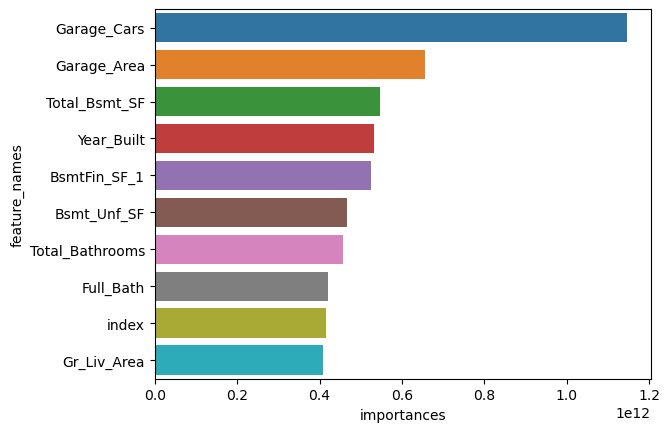

In [21]:
# 特徴量重要度の平均を算出して表を出力
display(feature_importance_df.groupby("feature_names").mean().sort_values("importances", ascending=False).head(10))
# 特徴量重要度を棒グラフで可視化
sns.barplot(x="importances", y="feature_names", 
            data=feature_importance_df.groupby("feature_names").mean().sort_values("importances", ascending=False)[:10].reset_index()
           )

In [23]:
# 提出ファイルを出力
submission.to_csv("fifth_submit.csv", index=False, header = False)

#### 参考サイト
https://qiita.com/ku_a_i/items/74241c84cda8c7327277
パラメータチューニング：　https://zenn.dev/robes/articles/d53ff6d665650f

上記のコードよくわからなかった
これやろうかな→https://www.kaggle.com/code/kojisan2020/simple-stacking